In [1]:
#imports
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('..')
import scipy as sp

from extremevalue.gpd import GEVMLE_ts

import pymc as pm
import pymc_experimental.distributions as pmx
import arviz as az

In [2]:
df_hourly_max = pd.read_pickle('prcp_hourly_max.pkl')
df_X = pd.read_pickle('stations_xy.pkl')

In [5]:
params = {}

for station in df_hourly_max:

    GEV_hourly = GEVMLE_ts()
    GEV_hourly.fit(df_hourly_max[station].fillna(0.0))
    station_params = GEV_hourly.get_params()
    station_params['10y'] = GEV_hourly.return_level(10)
    station_params['100y'] = GEV_hourly.return_level(100)
    station_params['10yse'] = GEV_hourly.return_level_se(10).item()
    station_params['100yse'] = GEV_hourly.return_level_se(100).item()
    params[station] = station_params

pd.DataFrame(params).T

,mu,sigma,xi,10y,100y,10yse,100yse
BOS,0.743041,0.218308,0.082367,1.282793,1.964037,0.091115,0.318363
BDL,0.866210,0.326382,0.082323,1.673127,2.691466,0.140195,0.549130
JFK,0.984831,0.323643,0.141936,1.842901,3.085250,0.155777,0.609815
LGA,0.999008,0.340878,-0.017883,1.750878,2.504331,0.112338,0.321120
EWR,1.010923,0.313233,0.165943,1.865461,3.173123,0.161646,0.696984
PHL,1.087505,0.381774,-0.018358,1.929132,2.771611,0.123407,0.335926
ILG,1.023899,0.317822,0.159448,1.884261,3.181259,0.164271,0.735896


In [6]:
df_annual_max = df_hourly_max.groupby(lambda x:x.year).max()
df_annual_max.max(), df_annual_max.mean(), df_annual_max.std()

(station
 BOS    2.03
 BDL    2.38
 JFK    2.88
 LGA    2.44
 EWR    3.24
 PHL    2.84
 ILG    2.69
 dtype: float64,
 station
 BOS    0.888302
 BDL    1.083019
 JFK    1.223019
 LGA    1.190943
 EWR    1.249245
 PHL    1.299623
 ILG    1.261698
 dtype: float64,
 station
 BOS    0.313968
 BDL    0.450126
 JFK    0.504406
 LGA    0.432854
 EWR    0.493102
 PHL    0.488034
 ILG    0.473037
 dtype: float64)

In [7]:
station = 'JFK'

ts_hourly_max = df_hourly_max[station]
ts_annual_max = df_annual_max[station]

GEV_hourly = GEVMLE_ts()
GEV_hourly.fit(ts_hourly_max)
GEV_hourly.get_params()

{'mu': 0.984831125432392,
 'sigma': 0.3236428951095842,
 'xi': 0.14193555821043535}

In [8]:
GEV_hourly.return_level(100)

3.085250101547203

In [94]:
def gev_returnlevel(rp, μ, σ, ξ):
    p = 1.0 / rp
    return μ - (σ / ξ) * (1 - np.power(-np.log(1.0 - p), -ξ))

In [10]:
data =ts_annual_max.values

# return_periods = GEV_hourly._return_periods(n=50)
return_periods = np.logspace(0.01,2, num=100)
p = 1/return_periods

with pm.Model() as model:
    # Priors
    μ = pm.Normal("μ", mu=1.0, sigma=0.5)
    σ = pm.HalfNormal("σ", sigma=0.5)
    ξ = pm.math.tanh(pm.Normal("ξ", mu=0, sigma=0.15))

    # Estimation
    gev = pmx.GenExtreme("gev", mu=μ, sigma=σ, xi=ξ, observed=data)
    # Return level
    z_p = pm.Deterministic("z_p", μ - σ / ξ * (1 - (-np.log(1 - p)) ** (-ξ)))
    z_p = pm.Deterministic("z_p", gev_returnlevel(return_periods, μ, σ, ξ))
    gev_returnlevel

Sampling: [gev, μ, ξ, σ]


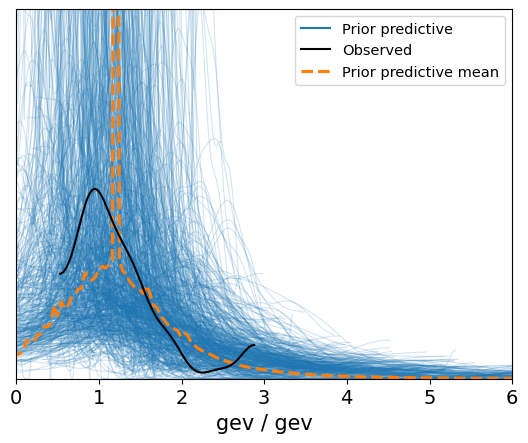

In [11]:
idata = pm.sample_prior_predictive(samples=1000, model=model)
az.plot_ppc(idata, group="prior")
ax = plt.gca()
ax.set_xlim([0, 6])
ax.set_ylim([0, 2]);

In [95]:
# az.plot_posterior(
#     idata, group="prior", var_names=["μ", "σ", "ξ"]
# );

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, ξ]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 24 seconds.


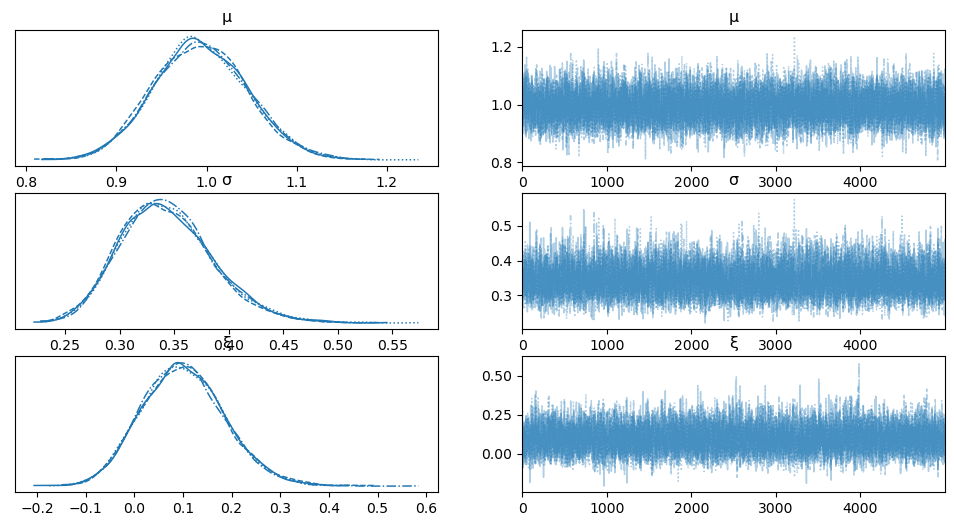

In [13]:
with model:
    trace = pm.sample(
        5000,
        # cores=4,
        # chains=4,
        # tune=2000,
        # initvals={"μ": -0.5, "σ": 1.0, "ξ": -0.1},
        target_accept=0.98,
    )
# add trace to existing idata object
idata.extend(trace)
az.plot_trace(idata, var_names=["μ", "σ", "ξ"]);

In [14]:
az.summary(idata,var_names=["μ", "σ", "ξ"],hdi_prob= 0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,0.994,0.052,0.896,1.098,0.001,0.000,10379.0,11686.0,1.0
σ,0.343,0.043,0.261,0.427,0.000,0.000,9917.0,11398.0,1.0
ξ,0.101,0.085,-0.067,0.264,0.001,0.001,8627.0,8408.0,1.0


In [15]:
z_p_summary = az.summary(idata,var_names=["z_p"],hdi_prob= 0.95)
z_p_summary.index = return_periods

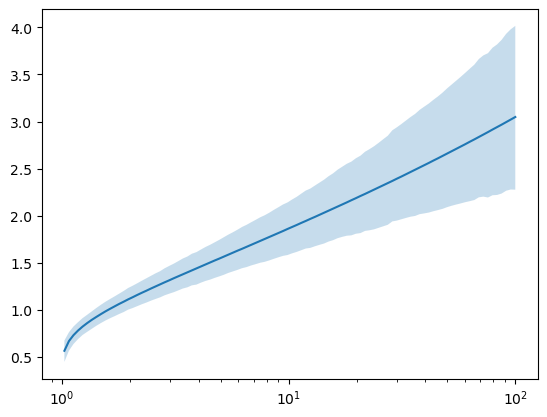

In [16]:
z_p_summary['mean'].plot()
plt.fill_between(z_p_summary.index,z_p_summary['hdi_2.5%'].values,z_p_summary['hdi_97.5%'].values,alpha=0.25)
plt.xscale("log")

In [17]:
GEV_hourly.return_level(100), GEV_hourly.return_level_se(100)

(3.085250101547203, array(0.60981525))

In [18]:
GEV_hourly.get_params()

{'mu': 0.984831125432392,
 'sigma': 0.3236428951095842,
 'xi': 0.14193555821043535}

In [57]:
sample_cols = df_annual_max.columns
sample_cols = ['JFK','LGA','EWR']

df_X_y = df_annual_max[sample_cols].stack().to_frame('PRCP').join(df_X)
X_ = df_X_y[['X','Y']].to_numpy()
y_ = df_X_y['PRCP'].to_numpy()
X_.shape, y_.shape

((159, 2), (159,))

In [22]:
f = 


SyntaxError: invalid syntax (2391194814.py, line 1)

In [58]:
#https://betanalpha.github.io/assets/case_studies/gp_part3/part3.html#4_adding_an_informative_prior_for_the_length_scale

coords = {
    "cov_params": ["mu","sigma","xi"],
}

p_10 = 0.1
p_100 = 0.01

with pm.Model(coords=coords) as gp_model:
    # ℓ = [100.0, 100.0, 100.0]
    # ℓ = pm.InverseGamma("ℓ", mu = 100.0, sigma = 200.0, dims = "cov_params")
    ℓ = pm.InverseGamma("ℓ", mu = 100.0, sigma = 20.0, dims = "cov_params")
    η = pm.Gamma("η", alpha=0.5, beta=0.5, dims = "cov_params")

    cov_μ = η[0]**2 * pm.gp.cov.ExpQuad(input_dim = 2, ls = ℓ[0])
    gp_μ = pm.gp.Latent(cov_func=cov_μ)
    μ = gp_μ.prior("μ", X=X_)

    cov_σ_log = η[1]**2 * pm.gp.cov.ExpQuad(input_dim = 2, ls = ℓ[1])
    gp_σ_log = pm.gp.Latent(cov_func=cov_σ_log)
    σ_log = gp_σ_log.prior("σ_log", X=X_)
    σ = pm.Deterministic("σ", pm.math.exp(σ_log))

    cov_ξ = η[2]**2 * pm.gp.cov.ExpQuad(input_dim = 2, ls = ℓ[2])
    gp_ξ = pm.gp.Latent(cov_func=cov_ξ)
    ξ = pm.math.tanh(gp_ξ.prior("ξ", X=X_))

    gev = pmx.GenExtreme("gev", mu=μ, sigma=σ, xi=ξ, observed=y_)

    # vi_approx = pm.fit()
    # gp_trace = vi_approx.sample(1000)

    gp_trace = pm.sample(1000, 
        tune=1000, 
        chains=2, 
        cores=2, 
        target_accept=0.98,
        nuts_sampler="numpyro"
        )

/Users/mosselveen/dev/extremeweather/.conda/lib/python3.10/site-packages/pymc/sampling/mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:06.846694
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  1:05:26.906577
Transforming variables...
Transformation time =  0:00:08.409238


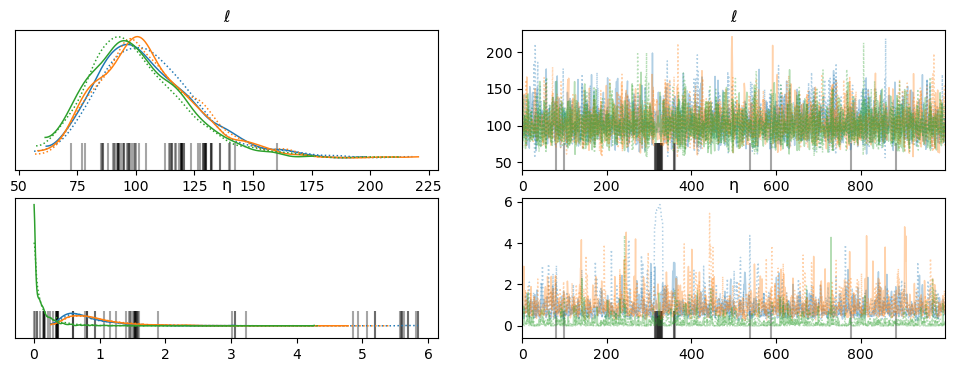

In [64]:
az.plot_trace(gp_trace, var_names=["ℓ", "η"]);

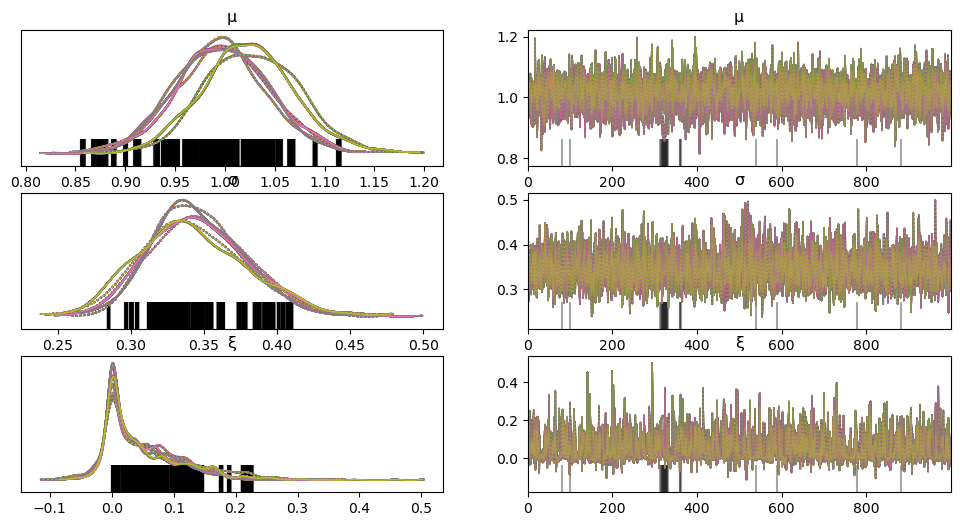

In [70]:
az.plot_trace(gp_trace, var_names=["μ", "σ", "ξ"]);

In [71]:
az.summary(gp_trace,var_names=["ℓ", "η"],hdi_prob= 0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ℓ[mu],105.589,21.702,67.368,149.575,0.417,0.312,2891.0,1464.0,1.00
ℓ[sigma],105.035,21.450,68.729,148.356,0.443,0.342,2629.0,1747.0,1.00
ℓ[xi],100.571,20.651,62.815,140.042,0.391,0.309,3499.0,1180.0,1.00
η[mu],0.930,0.673,0.281,2.020,0.051,0.044,665.0,310.0,1.01
η[sigma],1.004,0.580,0.243,2.077,0.019,0.013,880.0,1122.0,1.00
η[xi],0.166,0.276,0.000,0.618,0.009,0.007,532.0,803.0,1.01


In [72]:
az.summary(gp_trace,var_names=["μ", "σ", "ξ"],hdi_prob= 0.95).sort_values('r_hat')

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ[0],0.998,0.047,0.905,1.090,0.001,0.001,1887.0,1121.0,1.00
ξ[3],0.049,0.063,-0.036,0.183,0.002,0.001,1010.0,1687.0,1.00
ξ[2],0.057,0.073,-0.035,0.219,0.003,0.002,811.0,987.0,1.00
ξ[1],0.041,0.056,-0.041,0.167,0.002,0.001,1306.0,1932.0,1.00
ξ[0],0.049,0.063,-0.037,0.182,0.002,0.001,1013.0,1686.0,1.00
...,...,...,...,...,...,...,...,...,...
ξ[119],0.057,0.073,-0.034,0.219,0.003,0.002,806.0,987.0,1.01
ξ[89],0.057,0.073,-0.033,0.221,0.003,0.002,813.0,987.0,1.01
ξ[86],0.056,0.073,-0.032,0.223,0.003,0.002,812.0,965.0,1.01
ξ[26],0.057,0.073,-0.034,0.220,0.003,0.002,813.0,967.0,1.01


In [86]:
X_sample = df_X.loc[sample_cols][['X','Y']].to_numpy()
# X_sample = df_X[['X','Y']].to_numpy()

pred_vars = ["mu_pred", "sigma_log_pred", "xi_pred","z_p_10","z_p_100"]
jitter = 1e-6

with gp_model:
    mu_pred = gp_μ.conditional(pred_vars[0], Xnew=X_sample, jitter=jitter)
    sigma_log_pred = gp_σ_log.conditional(pred_vars[1], Xnew=X_sample, jitter=jitter)
    xi_pred = gp_ξ.conditional(pred_vars[2], Xnew=X_sample, jitter=jitter)

    z_p_10_pred = pm.Deterministic(pred_vars[3], gev_return_level(10.0, mu_pred, pm.math.exp(sigma_log_pred), pm.math.tanh(xi_pred)))
    z_p_100_pred = pm.Deterministic(pred_vars[4], gev_return_level(100.0, mu_pred, pm.math.exp(sigma_log_pred), pm.math.tanh(xi_pred)))


    posterior_pred = pm.sample_posterior_predictive(gp_trace, var_names=pred_vars)

Sampling: [mu_pred5, sigma_log_pred5, xi_pred5]
INFO:pymc.sampling.forward:Sampling: [mu_pred5, sigma_log_pred5, xi_pred5]


In [84]:
az.extract(posterior_pred.posterior_predictive, var_names="mu_pred").mean(axis=1)
az.extract(posterior_pred.posterior_predictive, var_names="xi_pred").mean(axis=1)
az.extract(posterior_pred.posterior_predictive, var_names="z_p_10").mean(axis=1)
az.extract(posterior_pred.posterior_predictive, var_names="z_p_100").mean(axis=1)
# az.extract(posterior_pred.posterior_predictive, var_names="xi_pred1").mean(axis=1)
# az.extract(posterior_pred.posterior_predictive, var_names="z_p_10").mean(axis=1)

<xarray.DataArray 'z_p_100_4' (z_p_100_4_dim_2: 3)>
array([2.81650951, 2.77046263, 2.85799086])
Coordinates:
  * z_p_100_4_dim_2  (z_p_100_4_dim_2) int64 0 1 2

In [53]:
# az.summary(gp_trace,hdi_prob= 0.95,var_names=["μ"]).mean()
# az.summary(gp_trace,hdi_prob= 0.95,var_names=["z_p_10"]).mean()
# az.summary(gp_trace,hdi_prob= 0.95,var_names=["z_p_100"]).mean()
# az.summary(gp_trace,hdi_prob= 0.95,var_names=["σ"]).mean()
# az.summary(gp_trace,hdi_prob= 0.95,var_names=["ξ"]).mean()
# az.summary(gp_trace,hdi_prob= 0.95,var_names=["η"]).mean()
# az.summary(gp_trace,hdi_prob= 0.95,var_names=["ℓ"]).mean()

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean          -0.247690
sd             0.335429
hdi_2.5%      -0.982164
hdi_97.5%      0.282722
mcse_mean      0.010714
mcse_sd        0.007571
ess_bulk     935.854447
ess_tail     942.738544
r_hat               NaN
dtype: float64

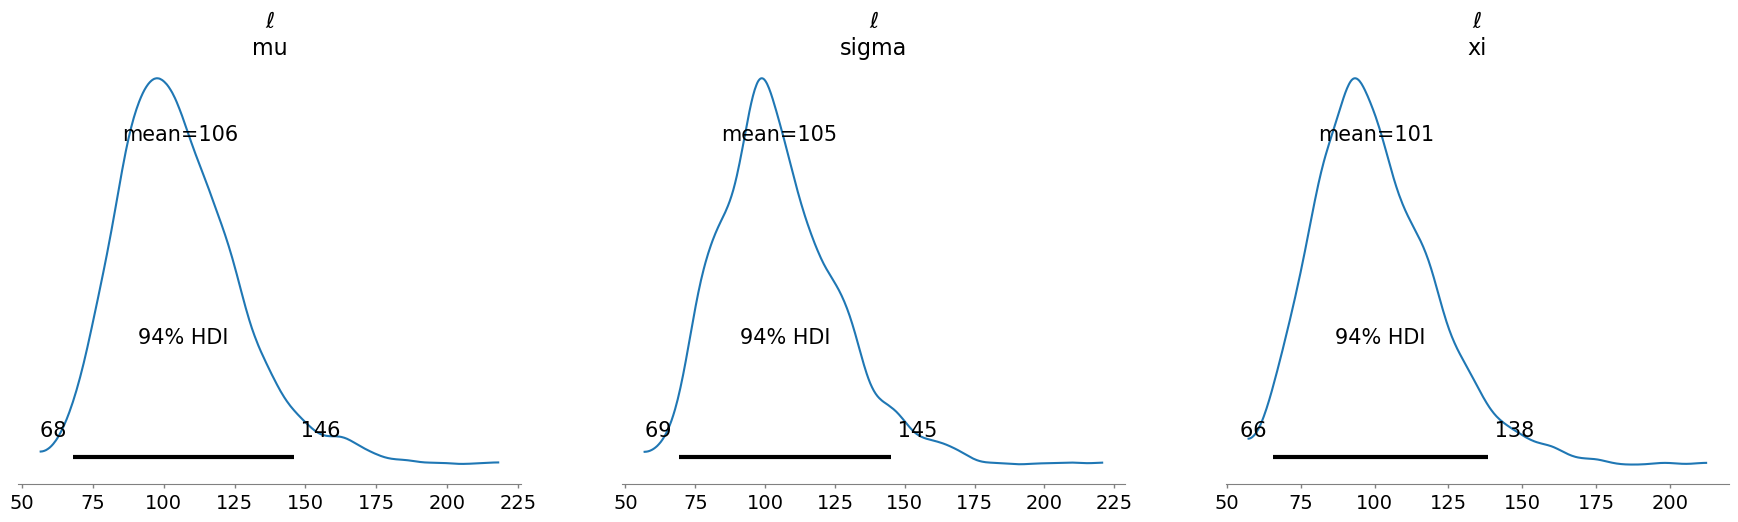

In [65]:
az.plot_posterior(
    gp_trace, group="posterior", var_names=["ℓ"]
);

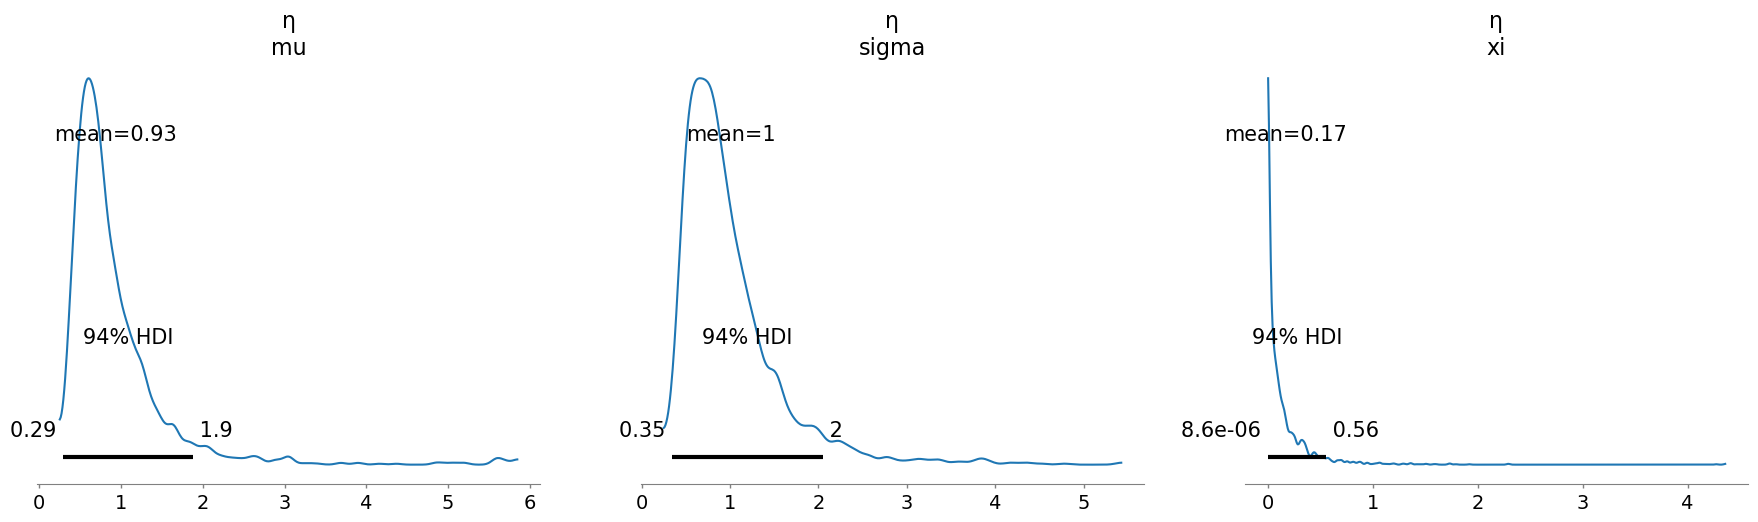

In [66]:
az.plot_posterior(
    gp_trace, group="posterior", var_names=["η"]
);

Sampling: [gev, mu_pred, sigma_log_pred, xi_pred, η, μ_rotated_, ξ_rotated_, σ_log_rotated_, ℓ]
INFO:pymc.sampling.forward:Sampling: [gev, mu_pred, sigma_log_pred, xi_pred, η, μ_rotated_, ξ_rotated_, σ_log_rotated_, ℓ]


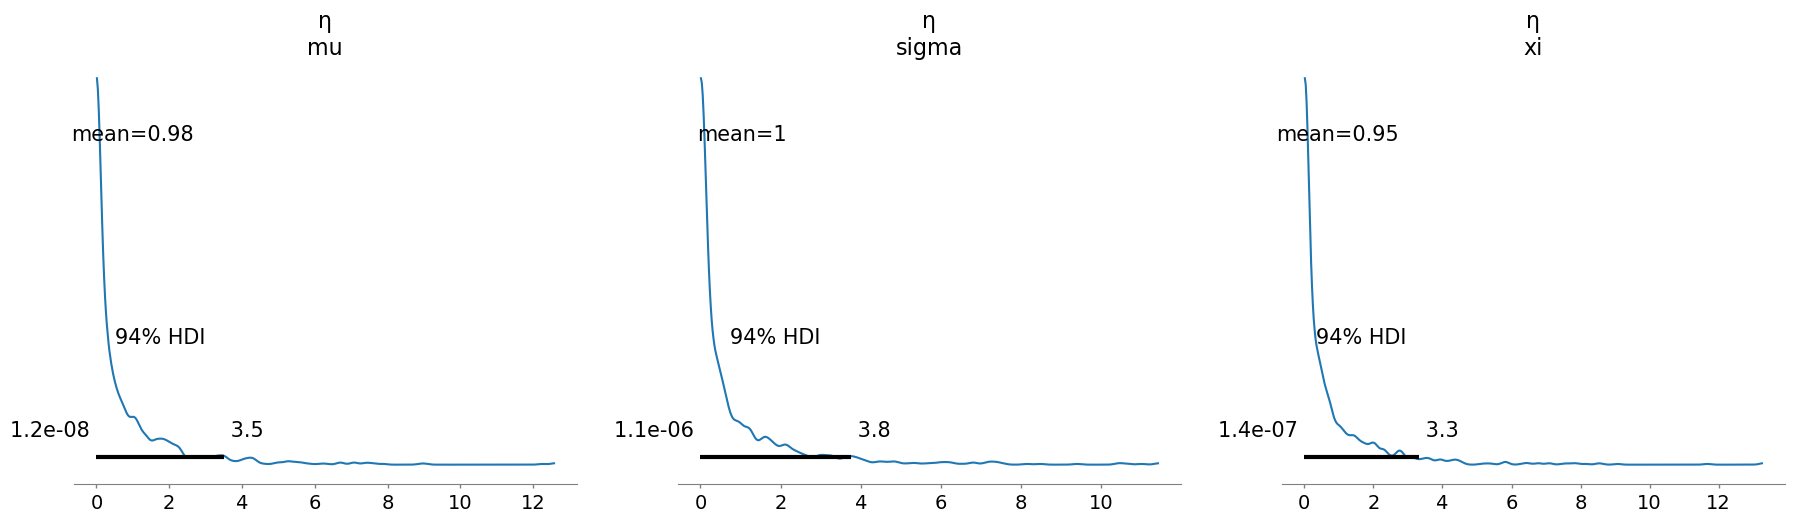

In [67]:
gp_idata = pm.sample_prior_predictive(samples=1000, model=gp_model)
# az.plot_ppc(gp_idata, group="prior")

# ax.set_ylim([0, 2]);

az.plot_posterior(
    gp_idata, group="prior", var_names=["η"]
);
# ax = plt.gca()
# ax.set_xlim([0, 500])
